In [37]:
import numpy as np
import pandas as pd
from datetime import date as dt
#importing stationarity test libraries for evaluating the time series
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,6
import warnings
warnings.filterwarnings('ignore')

In [3]:
#load the data
data=pd.read_csv('AirPassengers.csv')

In [4]:
data['Month'].head()

0    1949-01
1    1949-02
2    1949-03
3    1949-04
4    1949-05
Name: Month, dtype: object

In [5]:
#assigning the passengers data time series variable
ts=data['#Passengers']

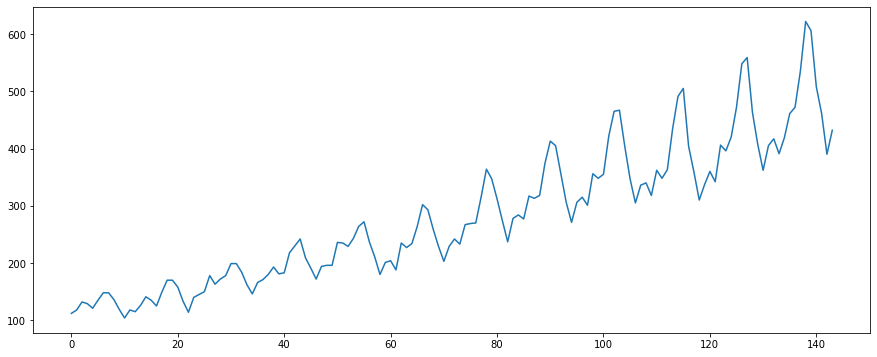

In [6]:
plt.plot(ts)
#there is an overall increase in the trend with some seasonality in it.

In [7]:
#transforming series using logD composition
ts_log=np.log(ts)

In [8]:
#stationarity check
#we will be writing function for performing rolling statistics and dicky fuller test
def test_stationarity(timeseries):
    #calculate the rolmean
    rolmean= timeseries.rolling(window=52, center=False).mean()
    #calculate the rolstandard deviation 
    rolstd= timeseries.rolling(window=52, center=False).std()
    #plot the rolling statistics
    orig=plt.plot(timeseries,color='blue',label='original')
    mean=plt.plot(rolmean,color='red',label='rolmean')
    std=plt.plot(rolstd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test')
    #initialize the dicky fuller test variable
    dftest=adfuller(timeseries,autolag='AIC')
    #initialize the output with the test statistic P value qnd other reauired vqriqbles
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used',
                                         'Number of Observations Used'])
    #initialize the critical value variable
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print(dfoutput)

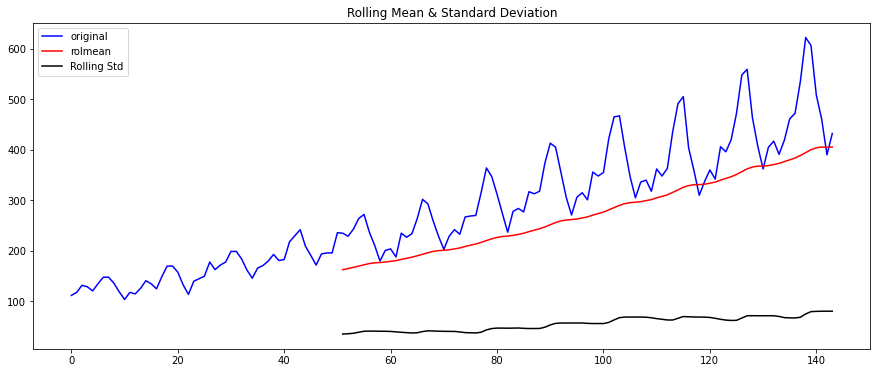

Results of Dickey-Fuller Test
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [9]:
#APPLY THE DATA TO THE FUNCTION
test_stationarity(data['#Passengers'])

In [10]:
'''by observing the plot and the result of the dicky fuller test we infer the test static 
is more than critical value and the moving average is not constant over time
so the null hypothesis of the dickey fuller test cannot be rejected.This shows
that the time series is not stationary '''

'by observing the plot and the result of the dicky fuller test we infer the test static \nis more than critical value and the moving average is not constant over time\nso the null hypothesis of the dickey fuller test cannot be rejected.This shows\nthat the time series is not stationary '

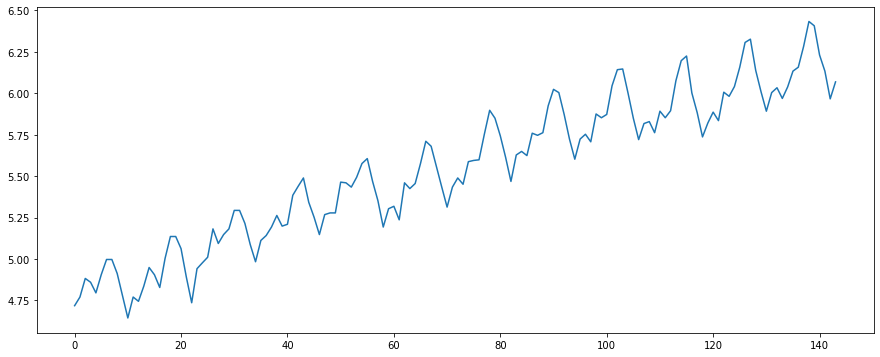

In [11]:
#let's plot the moving average
plt.plot(ts_log)

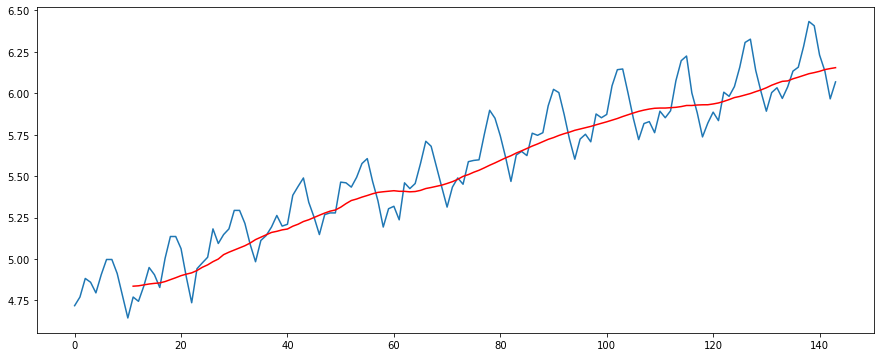

In [12]:
#initialize the moving average variable
movingAverage=ts_log.rolling(window=12).mean()
#initialize the moving STD
movingSTD=ts_log.rolling(window=12).std
#plot the data
plt.plot(ts_log)
#plot the moving average
plt.plot(movingAverage,color='red')


In [13]:
ts_log_mv_diff=ts_log-movingAverage

ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

11   -0.065494
12   -0.093449
13   -0.007566
14    0.099416
15    0.052142
16   -0.027529
17    0.139881
18    0.260184
19    0.248635
20    0.162937
Name: #Passengers, dtype: float64

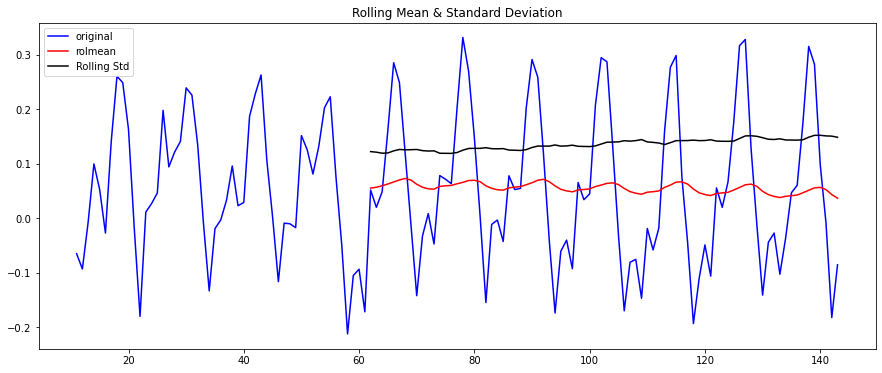

Results of Dickey-Fuller Test
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [14]:
#parse the time series data into the function that will check the stationarity
test_stationarity(ts_log_mv_diff)

In [15]:
'''the results of the dickey fuller test show that the test statistic is 
less than 1% of critical value that tells us that we are 99% confident that the series
is stationary.We can reject the null hypothesis'''

'the results of the dickey fuller test show that the test statistic is \nless than 1% of critical value that tells us that we are 99% confident that the series\nis stationary.We can reject the null hypothesis'

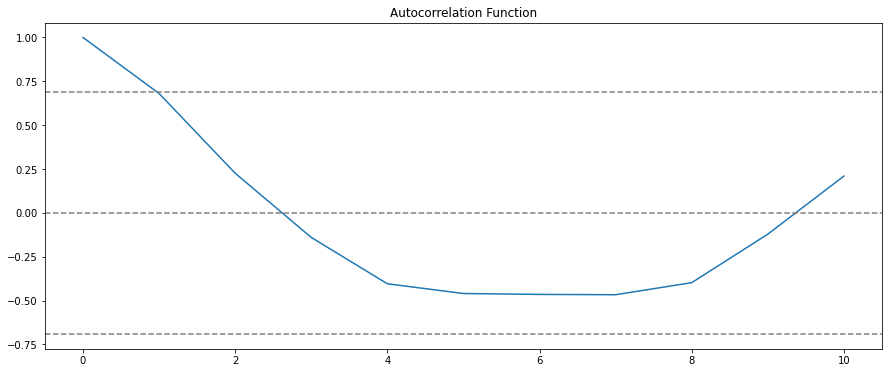

In [16]:
#AIR demo 2 
#plot the ACF 
#initialize the plt and applying ACF
plt.plot(np.arange(0,11),acf(ts_log_mv_diff,nlags=10))
#caculate the axis
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

In [17]:
'''the AFC curve crosses the upper confidence value when the lag value is between zero 
and 1 thus the optimal value of Q and the ARIMA model must be 0 or 1'''

'the AFC curve crosses the upper confidence value when the lag value is between zero \nand 1 thus the optimal value of Q and the ARIMA model must be 0 or 1'

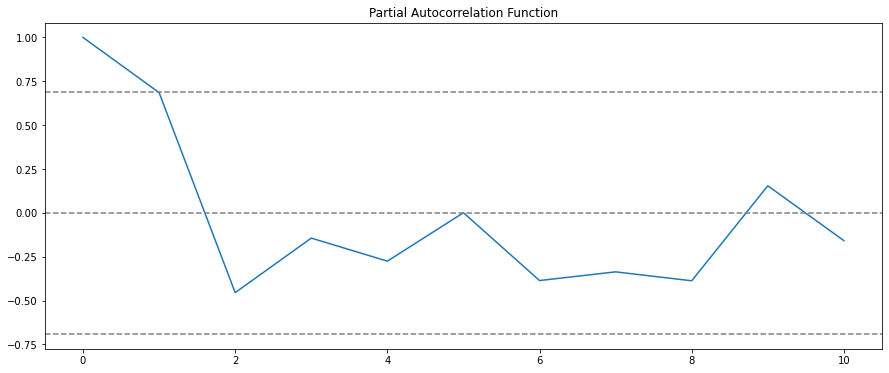

In [18]:
#plot the pacf
#initialize the plt and applying PACF
plt.plot(np.arange(0,11),pacf(ts_log_mv_diff,nlags=10))
#caculate the axis
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

In [19]:
'''the pacf curve drops to zero between lag values 1 and 2 thus the optimal
value of p in the ARIMA model is 1 or 2'''

'the pacf curve drops to zero between lag values 1 and 2 thus the optimal\nvalue of p in the ARIMA model is 1 or 2'

Text(0.5, 1.0, 'RSS:nan')

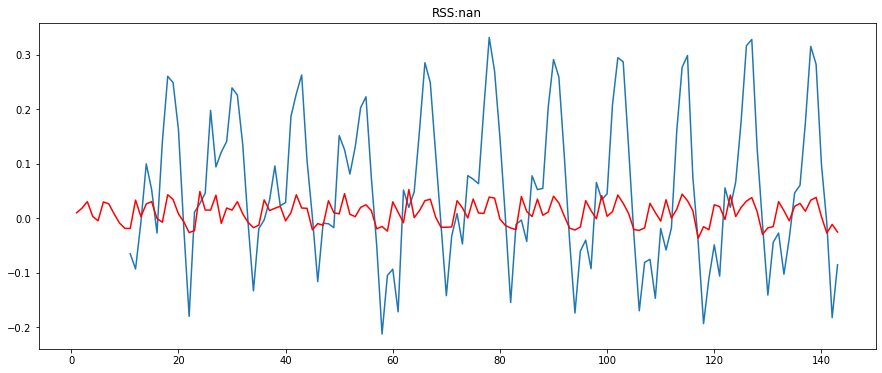

In [39]:
#let's apply the model
model=ARIMA(ts_log,order=(1,1,0))
results_ARIMA=model.fit(disp=-1)
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS:%.4f'% sum((results_ARIMA.fittedvalues[1:]-ts_log_mv_diff)**2))

In [40]:
#model predictions
#first step is to store the predicted results as a separate series
predictions_ARIMA_diff=pd.Series(results_ARIMA.fittedvalues,copy=True)
predictions_ARIMA_diff.head()
#if we notice here is that it starts from month 2 seeing that we took lag by 1
#and the first element doesn't have anything before to subtract from 

1    0.009676
2    0.018164
3    0.030130
4    0.003154
5   -0.005039
dtype: float64

In [41]:
'''the way to convert the differences to log scale is to add these differences
consecutively to the base number and easier way to do it is to firts determine
the cummulative sum at index and then add it to base number'''

'the way to convert the differences to log scale is to add these differences\nconsecutively to the base number and easier way to do it is to firts determine\nthe cummulative sum at index and then add it to base number'

In [43]:
predictions_ARIMA_diff_cumsum=predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()
#we can sum the current to the previous output to check if it is correct

1    0.009676
2    0.027839
3    0.057969
4    0.061123
5    0.056084
dtype: float64

In [44]:
#now we will add them to the base number
#we will create a series with all values as the base number and 
#add the differences to it
predictions_ARIMA_log=pd.Series(ts_log.iloc[0],index=ts_log.index)
predictions_ARIMA_log=predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()



0    4.718499
1    4.728175
2    4.746338
3    4.776468
4    4.779622
dtype: float64

Text(0.5, 1.0, 'RMSE: 52.1841')

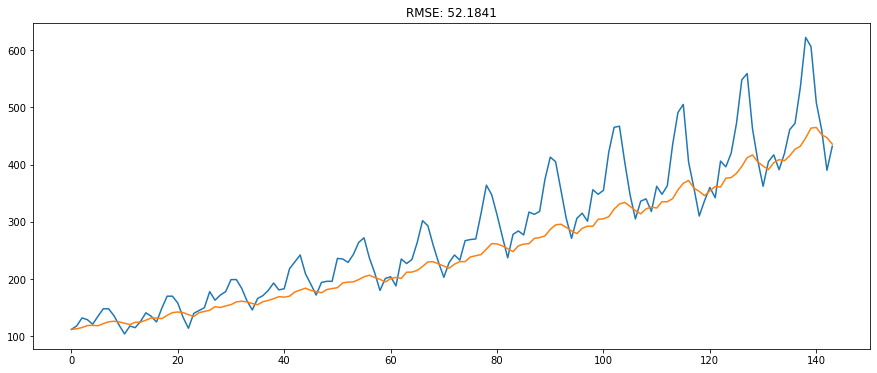

In [47]:
#forecast on the ofiginal scale
#initialize the ARIMA lodek
#plot the ARIMA predictions
#assigning RMSE value as the plot time
predictions_ARIMA=np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [ ]:
'''the orange curve is our prediction which has RMSE of 52.1841.
While our model is good at predicting the trend, it fails in capturing the seasonality'''
